This is based on the code found in [Tutorial 4: Inception, ResNet and DenseNet](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/04-inception-resnet-densenet.html)

In [1]:
import os
import urllib.request
from types import SimpleNamespace
from urllib.error import HTTPError

import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import seaborn as sns
import tabulate
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

%matplotlib inline
from IPython.display import HTML, display
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

# PyTorch
# Torchvision

In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/ConvNets")


# Function for setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

Seed set to 42


cuda:0


In [3]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial5/"
# Files to download
pretrained_files = [
    "GoogleNet.ckpt",
    "ResNet.ckpt",
    "ResNetPreAct.ckpt",
    "DenseNet.ckpt",
    "tensorboards/GoogleNet/events.out.tfevents.googlenet",
    "tensorboards/ResNet/events.out.tfevents.resnet",
    "tensorboards/ResNetPreAct/events.out.tfevents.resnetpreact",
    "tensorboards/DenseNet/events.out.tfevents.densenet",
]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

In [4]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0, 1, 2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0, 1, 2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


In [5]:
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(DATA_MEANS, DATA_STD)])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEANS, DATA_STD),
    ]
)
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
L.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
L.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


Seed set to 42
Seed set to 42


Files already downloaded and verified


In [6]:
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0, 2, 3]))
print("Batch std", imgs.std(dim=[0, 2, 3]))

Batch mean tensor([0.0231, 0.0006, 0.0005])
Batch std tensor([0.9865, 0.9849, 0.9868])


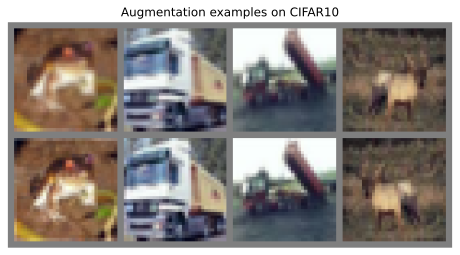

In [7]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [8]:
L.seed_everything(42)

Seed set to 42


42

In [9]:
class CIFARModule(L.LightningModule):
    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """CIFARModule.

        Args:
            model_name: Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams: Hyperparameters for the model, as dictionary.
            optimizer_name: Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams: Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)

    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here
            # for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        self.log("train_loss", loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log("test_acc", acc)

In [10]:
model_dict = {}


def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f'Unknown model name "{model_name}". Available models are: {str(model_dict.keys())}'

In [11]:
act_fn_by_name = {"tanh": nn.Tanh, "relu": nn.ReLU, "leakyrelu": nn.LeakyReLU, "gelu": nn.GELU}

In [12]:
def train_model(model_name, save_name=None, **kwargs):
    """Train model.

    Args:
        model_name: Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional): If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models
        # We run on a single GPU (if possible)
        accelerator="auto",
        devices=1,
        # How many epochs to train for if no patience is set
        max_epochs=180,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, mode="max", monitor="val_acc"
            ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = CIFARModule.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything(42)  # To be reproducible
        model = CIFARModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = CIFARModule.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path
        )  # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [13]:
class InceptionBlock(nn.Module):
    def __init__(self, c_in, c_red: dict, c_out: dict, act_fn):
        """InceptionBlock.

        Args:
            c_in: Number of input feature maps from the previous layers
            c_red: Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out: Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn: Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()

        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1), nn.BatchNorm2d(c_out["1x1"]), act_fn()
        )

        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn(),
        )

        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn(),
        )

        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn(),
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

In [14]:
class GoogleNet(nn.Module):
    def __init__(self, num_classes=10, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(
            num_classes=num_classes, act_fn_name=act_fn_name, act_fn=act_fn_by_name[act_fn_name]
        )
        self._create_network()
        self._init_params()

    def _create_network(self):
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), self.hparams.act_fn()
        )
        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
            InceptionBlock(
                64,
                c_red={"3x3": 32, "5x5": 16},
                c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8},
                act_fn=self.hparams.act_fn,
            ),
            InceptionBlock(
                64,
                c_red={"3x3": 32, "5x5": 16},
                c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12},
                act_fn=self.hparams.act_fn,
            ),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(
                96,
                c_red={"3x3": 32, "5x5": 16},
                c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12},
                act_fn=self.hparams.act_fn,
            ),
            InceptionBlock(
                96,
                c_red={"3x3": 32, "5x5": 16},
                c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16},
                act_fn=self.hparams.act_fn,
            ),
            InceptionBlock(
                96,
                c_red={"3x3": 32, "5x5": 16},
                c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16},
                act_fn=self.hparams.act_fn,
            ),
            InceptionBlock(
                96,
                c_red={"3x3": 32, "5x5": 16},
                c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24},
                act_fn=self.hparams.act_fn,
            ),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(
                128,
                c_red={"3x3": 48, "5x5": 16},
                c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16},
                act_fn=self.hparams.act_fn,
            ),
            InceptionBlock(
                128,
                c_red={"3x3": 48, "5x5": 16},
                c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16},
                act_fn=self.hparams.act_fn,
            ),
        )
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(128, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the
        # convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

In [15]:
model_dict["GoogleNet"] = GoogleNet

In [16]:
googlenet_model, googlenet_results = train_model(
    model_name="GoogleNet",
    model_hparams={"num_classes": 10, "act_fn_name": "relu"},
    optimizer_name="Adam",
    optimizer_hparams={"lr": 1e-3, "weight_decay": 1e-4},
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jiztom/anaconda3/envs/image-based-transformer/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.2.2. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint saved_models/ConvNets/GoogleNet.ckpt`
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti

Found pretrained model at saved_models/ConvNets/GoogleNet.ckpt, loading...


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

In [17]:
print("GoogleNet Results", googlenet_results)

GoogleNet Results {'test': 0.8970999717712402, 'val': 0.90420001745224}


In [19]:
# Import tensorboard
%load_ext tensorboard

In [20]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%tensorboard --logdir "/home/jiztom/PycharmProjects/image-based-transformer/Basic_DeepNet/saved_models/ConvNets/tensorboards/GoogleNet"


ResNet

In [21]:
class ResNetBlock(nn.Module):
    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """ResNetBlock.

        Args:
            c_in: Number of input features
            act_fn: Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in

        # Network representing F
        self.net = nn.Sequential(
            nn.Conv2d(
                c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False
            ),  # No bias needed as the Batch Norm handles it
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out),
        )

        # 1x1 convolution with stride 2 means we take the upper left value, and transform it to new output size
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        out = self.act_fn(out)
        return out